## Whisper Fine-Tuning
Whisper is a pre-trained model for automatic speech recognition (ASR) and speech translation. Trained on 680k hours of labelled data, Whisper models demonstrate a strong ability to generalise to many datasets and domains without the need for fine-tuning. In this notebook I will be finetuning the Latest Whisper Model, the 'whisper-small' from openAI using a pre defined dataset. This dataset can be easily swapped out to a custom data with verfied transcriptions.

In [1]:
!pip install --upgrade pip
!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 953.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:
from huggingface_hub import notebook_login

notebook_login()


### Dataset for Fine-Tuning
Common Voice is a series of crowd-sourced datasets where speakers record text from Wikipedia in various languages. I'll use the latest edition of the Common Voice dataset at the time of writing (version 17). I will be fine tuning the model on Telugu, which is a Dravidian language predominantly spoken in the Indian states of Andhra Pradesh and Telangana. Common Voice 17 currently consists of 110 rows of training data and 49 rows of test data. To access this dataset, you will need to accept the terms and conditions for first time users [here](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0/viewer/te/test).

In [7]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_17_0", "te", split="train+validation", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_17_0", "te", split="test", use_auth_token=True)



/usr/local/lib/python3.10/dist-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_17_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_17_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 62it [00:00, 41179.23it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 48it [00:00, 41873.25it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 49it [00:00, 82638.08it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 1732it [00:00, 103226.07it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 18it [00:00, 10921.09it/s]


Generating validated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 224it [00:00, 62356.41it/s]


In [8]:
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes","variant"])


Most ASR datasets only provide input audio samples (audio) and the corresponding transcribed text (sentence). Common Voice contains additional metadata information, such as accent and locale, which I can disregard for ASR. Keeping the notebook as general as possible, I only consider the input audio and transcribed text for fine-tuning, discarding the additional metadata information:

In [12]:
print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 110
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 49
    })
})


### Setting up Training Pipeline
The ASR pipeline can be de-composed into three components:


1.   A feature extractor which pre-processes the raw audio-inputs
2.   The model which performs the sequence-to-sequence mapping
3.   A tokenizer which post-processes the model outputs to text format

In Huggingface Transformers, the Whisper model has an associated feature extractor and tokenizer, called WhisperFeatureExtractor and WhisperTokenizer respectively.



Speech signals, represented as 1-dimensional arrays of amplitude values, are discretized by sampling at fixed intervals, measured in Hertz (Hz). Higher sampling rates yield better approximations of the continuous signal but require more storage. It's crucial to match the audio's sampling rate to the model's expected rate; for Whisper, this is 16kHz. The Whisper feature extractor pads or truncates audio samples to 30 seconds and converts them into log-Mel spectrograms, visual representations of frequencies over time, which the model uses as input. This extractor simplifies preprocessing by handling padding and spectrogram conversion in a single step.

In [ ]:
from transformers import WhisperFeatureExtractor                                        # Loading the Feature Extractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")


The Whisper tokenizer converts the model's output text tokens into actual text strings (e.g., [1169, 3797, 3332] -> "the cat sat"). Unlike encoder-only ASR models requiring dataset-specific CTC tokenizers, the encoder-decoder Whisper model can use a pre-trained tokenizer. This tokenizer is trained on transcriptions from 96 languages, making it suitable for multilingual ASR tasks. For fine-tuning, such as for Telugu, I only need to set the target language and task, enabling the tokenizer to prepend the appropriate language and task tokens to the encoded sequences.

In [ ]:
from transformers import WhisperTokenizer                                                                      # Loading the Tokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Telugu", task="transcribe")


tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Verifying that the tokenizer correctly encodes Telugu characters by encoding and decoding the first sample of the Common Voice dataset

In [ ]:
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")


Input:                 ఆ మందహాసమని భావము
Decoded w/ special:    <|startoftranscript|><|te|><|transcribe|><|notimestamps|>ఆ మందహాసమని భావము<|endoftext|>
Decoded w/out special: ఆ మందహాసమని భావము
Are equal:             True


Combining both the Feature Extractor and Tokenizer into a WhisperProcessor class. This processor object Inherits from WhisperFeatureExtractor and WhisperProcessor and in doing so I only need to keep track of two objects during training, the processor and the model.

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Telugu", task="transcribe")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Checking the format of the training data we can see that there's a 1 dimensional input audio array and it's corresponding target transcription. We can also see that the sampling rate is at 48Khz, which is not compatible with our model. So I need to downsample the input data to fit our model.

In [ ]:
print(common_voice["train"][0])


{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/0c98b228eb447949380e07b331a3c187c1ea9aee56c5682677ef089e84e95761/te_train_0/common_voice_te_40116810.mp3', 'array': array([ 2.27373675e-12,  4.54747351e-12,  9.09494702e-13, ...,
        2.23108782e-06, -1.76195226e-06, -2.78278867e-06]), 'sampling_rate': 48000}, 'sentence': 'ఆ మందహాసమని భావము'}


This downsampling can be performed using the dataset's cast_column method that signals the dataset to downsample the audio on the fly the first time that the data is loaded.

In [ ]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))


To verify the downsampling operation I print the first audio sample in the dataset, and from the output I can see that the downsampling is successfull.

In [ ]:
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/0c98b228eb447949380e07b331a3c187c1ea9aee56c5682677ef089e84e95761/te_train_0/common_voice_te_40116810.mp3', 'array': array([-6.54836185e-11, -4.36557457e-11,  5.82076609e-11, ...,
        1.37966435e-06,  4.56366342e-06,  1.15768171e-06]), 'sampling_rate': 16000}, 'sentence': 'ఆ మందహాసమని భావము'}


I'm creating to prepare the dataset for training the incorporates all the previous steps at once. This function :


1.   Loads and resamples the audio data by calling batch["audio"]. As explained above, Huggingface Datasets performs any necessary resampling operations on the fly.
2.   Uses the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array.
3. Encodes the transcriptions to label ids through the use of the tokenizer.



In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch


Applying the data preparation function to all the training data using dataset's .map method.

In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=4)


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/110 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/49 [00:00<?, ? examples/s]

Now that the dataset has been prepared, I will move onto creating a pipeline to train the model. The Huggingface Trainer will do most of the work I just have to do the following steps:



1.   Load a pre-trained checkpoint: we need to load a pre-trained checkpoint and configure it correctly for training.
2.   Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model.
3.   Evaluation metrics: during evaluation, we want to evaluate the model using the word error rate (WER) metric. We need to define a compute_metrics function that handles this computation.
4.   Define the training arguments: these will be used by the 🤗 Trainer in constructing the training schedule.

Loading a pre-trained checkpoing

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")


config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

Although the whisper model can recognise the input audio at the time of inference, it is good to set the language explicitly this negates the scenarios when the incorrect language is predicted. Causing the predicted text to diverge from the true language during generation. So I explicilty set the language and the task parameters.

In [ ]:
model.generation_config.language = "telugu"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None


Defining the Data Collator:
The data collator for a sequence-to-sequence speech model processes input_features and labels independently. Input_features, already padded to 30 seconds and converted to log-Mel spectrograms, are simply converted to batched PyTorch tensors using the feature extractor's .pad method with return_tensors=pt. For labels, which are initially un-padded, sequences are padded to the maximum length in the batch using the tokenizer's .pad method. Padding tokens are replaced with -100 to ignore them in loss computation. The start token of the transcript is removed from the beginning of the label sequence, as it is appended during training. The WhisperProcessor is used to handle both feature extraction and tokenization.

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


Initialising the data collator

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)


### Evaluation Metrics:

Now, I define the evaluation metric to use on the evaluation set. I use the usual Word Error Rate('WER') which is the common metric used to measure ASR systems. I'll be loading the metric from evaluate library.

In [ ]:
import evaluate

metric = evaluate.load("wer")


I then create a function to measure the WER metric. This function first replaces the -100 value in the label_id variable with its corresponding pad_token_id. It then decodes the predicted and label ids to strings. It then computes the WER between the predicted and the reference labels.

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


In this step I will define the training arguments for the pipeline. All of the parameters are explained below:


1.   output_dir="./whisper-small-te": Specifies the directory to save the model checkpoints and other outputs.
2.   per_device_train_batch_size=16: Sets the number of training samples processed simultaneously per GPU.
3.   gradient_accumulation_steps=1: Accumulates gradients over this many steps before performing a backward pass.
4.   learning_rate=1e-5: Defines the learning rate for the optimizer.
5.   warmup_steps=100: Uses 100 steps for a gradual increase in learning rate from zero to the specified learning rate.
6.   max_steps=500: Limits the training process to 500 optimization steps.
7.   gradient_checkpointing=True: Saves memory by only keeping some layers' forward pass outputs.
8.   fp16=True: Enables mixed precision training to speed up computations and reduce memory usage.
9.   evaluation_strategy="steps": Evaluates the model at regular step intervals.
10.  per_device_eval_batch_size=8: Sets the number of evaluation samples processed simultaneously per GPU.
11.  predict_with_generate=True: Generates predictions during evaluation, which is useful for sequence-to-sequence tasks.
12.  generation_max_length=225: Caps the length of generated sequences during prediction.
13.  save_steps=500: Saves model checkpoints every 500 steps.
14.  eval_steps=500: Evaluates the model every 500 steps.
15.  logging_steps=100: Logs training metrics every 100 steps.
16.  report_to=["tensorboard"]: Logs metrics to TensorBoard for visualization.
17.  load_best_model_at_end=True: Loads the best model found during training at the end of the process.
18.  metric_for_best_model="wer": Uses Word Error Rate (WER) to evaluate and select the best model.
19.  greater_is_better=False: Indicates that a lower value of the selected metric (WER) is better.
20.  push_to_hub=True: Pushes the model to the Hugging Face Hub after training.


PLEASE NOTE, I have chosen a pretty low values for the warmup and the max steps as I am GPU poor and cannot afford to train the model for a very long time, this notebook is to just show how the whisper model can be finetuned.

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-te",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=100,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=150,
    save_steps=500,
    eval_steps=500,
    logging_steps=100,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Now we forward these arguments, model, dataset, data_collator and compute_metrics to the trainer.

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)


max_steps is given, it will override any value given in num_train_epochs


Start the training by this command.

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
500,0.000100,0.713933,87.362637


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=500, training_loss=0.2015934666879475, metrics={'train_runtime': 2095.4416, 'train_samples_per_second': 3.818, 'train_steps_per_second': 0.239, 'total_flos': 2.26770407571456e+18, 'train_loss': 0.2015934666879475, 'epoch': 71.42857142857143})

After the training is complete, I will push the model ato the huggingface-hub. To make the model more accessible, I will include appropriate tages in the README information as such.

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_17_0",
    "dataset": "Common Voice 17.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: te, split: test",
    "language": "te",
    "model_name": "Whisper small Te sample - Prajwal Nagaraj",  # a 'pretty' name for your model
    "finetuned_from": "openai/whisper-small-te",
    "tasks": "automatic-speech-recognition",
}


Pushing the model to the Hug with the following command

In [ ]:
trainer.push_to_hub(**kwargs)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


CommitInfo(commit_url='https://huggingface.co/Prajwalll/whisper-small-te/commit/f439372bd646793628e1a105cc9432c0dec82b8d', commit_message='End of training', commit_description='', oid='f439372bd646793628e1a105cc9432c0dec82b8d', pr_url=None, pr_revision=None, pr_num=None)

### Training Results

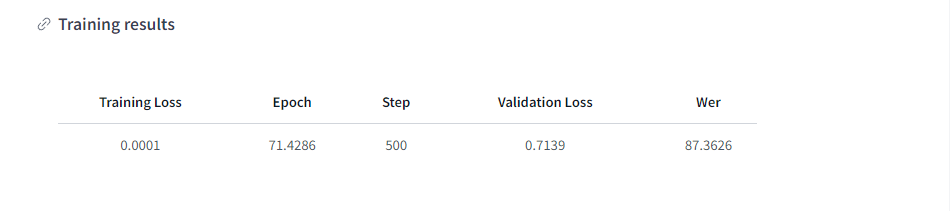

The model can be found at https://huggingface.co/Prajwalll/whisper-small-te

From the results we can see that the WER is pretty high this is because I trained the model for a very less time and the warmup and the max_steps arguments for the training command were very low as I cannot afford to train the model for large durations of time because GPU's are very expensive. The purpose of this notebook was only to demonstrate how the pre trained whisper model's checkpoints can be fine tuned further.

### Testing the model after training
The model can be downloaded from the Huggingface Hub and used to run inference on unseen test data, but I do not recommend this as the WER is too high for this model.